<h1> Matsubara fitting for data generated by discrete poles </h1>


In this note, let us illustrate how to perform Matsubara fitting using test data generated by discrete poles with random weights.

Let us first define the inverse temperature $\beta$ and Matsubara frequencies $\{Z_n\}$:

$$
Z_n = \mathrm i \frac{(2n+1)\pi}{\beta}.
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from aaadapol import hybfit

beta = 20
N = 55
Z = 1j *(np.linspace(-N, N, N + 1)) * np.pi / beta

We will generate Matsubara data evaluated on $\{Z_n\}$ using the following formula:
$$
\begin{aligned}
G(\mathrm i\nu_n)& = \sum_{k=1}^{N_p} \frac{|v_k\rangle\langle v_k|}{\mathrm i\nu_n - E_k},
\end{aligned}
$$
Where $|v_k\rangle$ is a $N_{\text{orb}}\times 1$ vector, where $N_{\text{orb}}$ is the number of orbitals.

Below is the code for making a $N_{\text{orb}}$-dimensional Matsubara data on Matsubara frequencies $Z$, by summing with $N_p$ discrete poles.

In [2]:
def make_Delta_with_random_discrete_pole(Norb, Np, Z):
    np.random.seed(0)
    pol = np.cos((2*np.arange(Np)+1) * np.pi / (2*Np) ) 
    vec = np.random.randn(Norb, Np) + 1j * np.random.randn(Norb, Np)
    weight = np.array(
        [vec[:, i, None] * np.transpose(np.conj(vec[:, i])) for i in range(Np)]
    )

    pol_t = np.reshape(pol, [pol.size, 1])
    M = 1 / ( Z - pol_t)
    M = M.transpose()
    if len(weight.shape) == 1:
        weight = weight / sum(weight)
        Delta = M @ weight
    else:
        Nw = len(Z)
        Delta = (M @ (weight.reshape(Np, Norb * Norb))).reshape(Nw, Norb, Norb)
    return pol, weight, Delta

An example Matsubara data would look like the following:

Text(0.5, 1.0, 'Matsubara data')

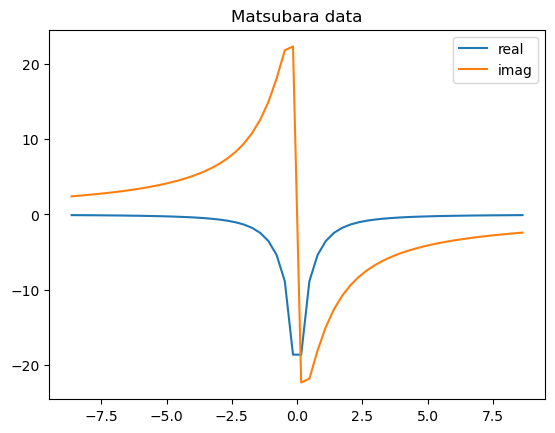

In [3]:
pol, weight, Delta = make_Delta_with_random_discrete_pole(Norb=1, Np = 10, Z=Z)

plt.plot(Z.imag, Delta[:, 0, 0].real, label='real')
plt.plot(Z.imag, Delta[:, 0, 0].imag, label='imag')
plt.legend()
plt.title("Matsubara data")

Let us first test the Matsubara fitting for scalar-valued Matsubara functions.

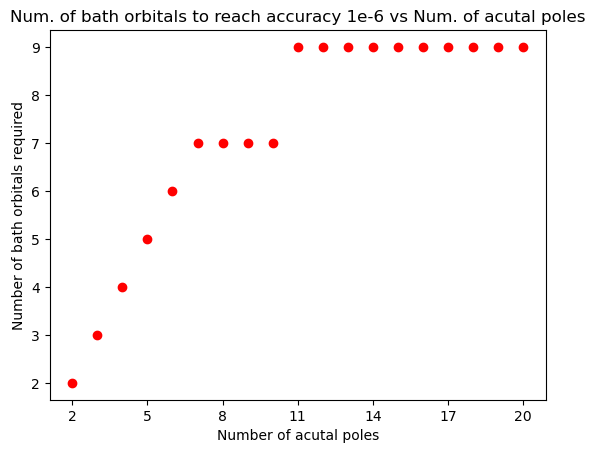

In [4]:
tol = 1e-6 #Fitting tolerance

for Np in range(2, 21):
    pol, weight, Delta = make_Delta_with_random_discrete_pole(Norb=1, Np = Np, Z=Z)
    bathenergy, bathhyb, final_error, func = hybfit(Delta, Z, tol=tol)
    assert(final_error < tol)
    plt.plot(Np, len(bathenergy),"ro")
plt.xlabel("Number of acutal poles")
plt.ylabel("Number of bath orbitals required")
plt.title("Num. of bath orbitals to reach accuracy 1e-6 vs Num. of acutal poles")
plt.xticks(range(2, 21,3))
plt.show()

Similarly, we can test for matrix-valued Matsubara functions:

In [5]:
tol = 1e-6
Norb = 4

for Np in range(2, 10):
    pol, weight, G = make_Delta_with_random_discrete_pole(Norb=Norb, Np = Np, Z=Z)
    bathenergy, bathhyb, final_error, func = hybfit(G, Z, tol=tol)
    assert(final_error < tol)

One can also conduct Matsubara fitting via specifying number of modes $N_p$ in the hybfit function:

In [6]:
pol, weight, G = make_Delta_with_random_discrete_pole(Norb=4, Np = 10, Z=Z)
bathenergy, bathhyb, final_error, func = hybfit(G, Z, Np=15)
print("Numer of bath orbitals is ", len(bathenergy))
print("Final error is ", final_error)

Numer of bath orbitals is  10
Final error is  6.189103600097627e-10


<h2> Triqs Interface </h2>

Let us demonstrate how to use our code if the Matsubara functions are given using the TRIQS data structure. 

In trqis, the Matsubara frequencies are defined using `MeshImFreq`:

In [7]:
from triqs.gf import MeshImFreq
Norb = 1
iw_mesh = MeshImFreq(beta=beta, S='Fermion', n_iw=Z.shape[0]//2)

The `hybfit_triqs` function could handle TRIQS Green's functions object `GF` and `BlockGf`:

In [8]:
from triqs.gf import Gf, BlockGf
from aaadapol import hybfit_triqs
Norb = 1
for Np in range(2, 21):
    pol, weight, Delta = make_Delta_with_random_discrete_pole(Norb=Norb, Np = Np, Z=Z)

    #Construct Gf object
    delta_iw = Gf(mesh=iw_mesh, target_shape=[Norb, Norb])
    delta_iw.data[:] = Delta

    #Construct BlockGf object
    delta_blk = BlockGf(name_list=['up', 'down'], block_list=[delta_iw, delta_iw], make_copies=True)

    # Gf interface for hybridization fitting
    V, eps, delta_fit, final_error = hybfit_triqs(delta_iw, tol=tol, maxiter=50, debug=True)
    assert final_error < tol

    # BlockGf interface for hybridization fitting
    V, eps, delta_fit, final_error = hybfit_triqs(delta_blk, tol=tol, maxiter=50, debug=True)
    assert final_error[0] < tol and final_error[1] < tol

optimization finished with fitting error 2.701e-15
optimization finished with fitting error 2.701e-15
optimization finished with fitting error 2.701e-15
optimization finished with fitting error 1.081e-14
optimization finished with fitting error 1.081e-14
optimization finished with fitting error 1.081e-14
optimization finished with fitting error 1.099e-14
optimization finished with fitting error 1.099e-14
optimization finished with fitting error 1.099e-14
optimization finished with fitting error 2.220e-14
optimization finished with fitting error 2.220e-14
optimization finished with fitting error 2.220e-14
optimization finished with fitting error 2.892e-14
optimization finished with fitting error 2.892e-14
optimization finished with fitting error 2.892e-14
optimization finished with fitting error 1.905e-14
optimization finished with fitting error 1.905e-14
optimization finished with fitting error 1.905e-14
optimization finished with fitting error 4.401e-07
optimization finished with fitt